# Manga Dialogue Detection with OCR Application

## Introduction

After I finish the entire coding cycle for object detection in [Part 1](https://github.com/catptype/DeepLearning-SelfStudy/blob/main/04%20-%20Object%20Detection%20(Part%201).ipynb) and [Part 2](https://github.com/catptype/DeepLearning-SelfStudy/blob/main/05%20-%20Object%20Detection%20(Part%202).ipynb) ipynb notebooks, I developed a simple application for detecting manga dialogues from a full page of manga (or comic book page). The detection results will be processed with [Tesseract-OCR](https://github.com/tesseract-ocr/tesseract)※, an Optical Character Recognition (OCR) tool that converts an image of text into a machine-readable text format. This extracted text will be utilized for future use cases, such as Text-To-Speech (TTS). The image below illustrates what manga dialogues look like:

<div style="display: flex; justify-content: center;">
  <div style="margin: 10px;">
    <figure style="text-align: center;">
      <img src="https://raw.githubusercontent.com/catptype/DeepLearning-SelfStudy/main/samples/MangaDialogue/EN/01.jpg" style="max-height:300px;width:auto">
      <figcaption>English dialogue 1</figcaption>
    </figure>
  </div>
  <div style="margin: 10px;">
    <figure style="text-align: center;">
      <img src="https://raw.githubusercontent.com/catptype/DeepLearning-SelfStudy/main/samples/MangaDialogue/EN/02.jpg" style="max-height:300px;width:auto">
      <figcaption>English dialogue 2</figcaption>
    </figure>
  </div>
  <div style="margin: 10px;">
    <figure style="text-align: center;">
      <img src="https://raw.githubusercontent.com/catptype/DeepLearning-SelfStudy/main/samples/MangaDialogue/EN/03.jpg" style="max-height:300px;width:auto">
      <figcaption>English dialogue 3</figcaption>
    </figure>
  </div>
  <div style="margin: 10px;">
    <figure style="text-align: center;">
      <img src="https://raw.githubusercontent.com/catptype/DeepLearning-SelfStudy/main/samples/MangaDialogue/EN/04.jpg" style="max-height:300px;width:auto">
      <figcaption>English dialogue 4</figcaption>
    </figure>
  </div>
  <div style="margin: 10px;">
    <figure style="text-align: center;">
      <img src="https://raw.githubusercontent.com/catptype/DeepLearning-SelfStudy/main/samples/MangaDialogue/EN/05.jpg" style="max-height:300px;width:auto">
      <figcaption>English dialogue 5</figcaption>
    </figure>
  </div>
</div>

<div style="display: flex; justify-content: center;">
  <div style="margin: 10px;">
    <figure style="text-align: center;">
      <img src="https://raw.githubusercontent.com/catptype/DeepLearning-SelfStudy/main/samples/MangaDialogue/JP/01.png" style="max-height:300px;width:auto">
      <figcaption>Japanese dialogue 1</figcaption>
    </figure>
  </div>
  <div style="margin: 10px;">
    <figure style="text-align: center;">
      <img src="https://raw.githubusercontent.com/catptype/DeepLearning-SelfStudy/main/samples/MangaDialogue/JP/02.png" style="max-height:300px;width:auto">
      <figcaption>Japanese dialogue 2</figcaption>
    </figure>
  </div>
  <div style="margin: 10px;">
    <figure style="text-align: center;">
      <img src="https://raw.githubusercontent.com/catptype/DeepLearning-SelfStudy/main/samples/MangaDialogue/JP/03.png" style="max-height:300px;width:auto">
      <figcaption>Japanese dialogue 3</figcaption>
    </figure>
  </div>
  <div style="margin: 10px;">
    <figure style="text-align: center;">
      <img src="https://raw.githubusercontent.com/catptype/DeepLearning-SelfStudy/main/samples/MangaDialogue/JP/04.jpg" style="max-height:300px;width:auto">
      <figcaption>Japanese dialogue 4</figcaption>
    </figure>
  </div>
  <div style="margin: 10px;">
    <figure style="text-align: center;">
      <img src="https://raw.githubusercontent.com/catptype/DeepLearning-SelfStudy/main/samples/MangaDialogue/JP/05.jpg" style="max-height:300px;width:auto">
      <figcaption>Japanese dialogue 5</figcaption>
    </figure>
  </div>
</div>

※: To use [Tesseract-OCR](https://github.com/tesseract-ocr/tesseract) with Python, [pytesseract](https://pypi.org/project/pytesseract/) is required.

## Demonstration

Let's do some examples of OCR for both English and Japanese dialogues. To achieve optimal results, it is recommended to use grayscale images with additional image processing. In this application, I employ a sequence of operations including blur, sharpening, and black hat morphological operation. 

### Tesseract-OCR Configuration:
- OCR Engine Mode (OEM) = 3
- Page Segmentation Mode (PSM) = 4 for English (may switch to 3 in failure cases)
- Page Segmentation Mode (PSM) = 3 for Japanese (may switch to 5 in failure cases)

For OEM and PSM configuration details, please refer to the `Appendix` section at the bottom of this ipynb Notebook.

In [1]:
import sys
sys.dont_write_bytecode = True

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pytesseract import pytesseract
from module.utility.DirectoryProcessor import DirectoryProcessor

class ImageProcessing:

    @staticmethod
    def blur(image, kernel=(5, 5)):
        image = cv2.GaussianBlur(image, kernel, 0)
        return image
    
    @staticmethod
    def sharpening(image):
        kernel = np.array([[-1, -1, -1],
                           [-1,  9, -1],
                           [-1, -1, -1]])
        image = cv2.filter2D(image, -1, kernel)
        return image
    
    @staticmethod
    def binary(image):
        _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return image

    @staticmethod
    def blackhat(image, kernel=(15,15)):
        rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel)
        image = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, rectKernel)
        return image
    
    @staticmethod
    def invert(image):
        image = 255 - image
        return image
    
class Image2Text:
    
    @staticmethod
    def eng(image, oem=3, psm=4): 
        # psm = [3,4,6,11] compatible for english
        # psm = [3,4] perform good result
        text = pytesseract.image_to_string(
                image, 
                lang='eng',
                config=f'--oem {oem} --psm {psm}',
            ).replace("\n"," ")
        while "  " in text:
            text = text.replace("  ", " ")
        return text
    
    @staticmethod
    def jpn_vert(image, oem=3, psm=3):
        # psm = [1,3,5,12] compatible with vertical japanese
        # psm = [1,3] perform good result
        # psm = 5 best for rectangle dialogue
        # psm = 12 perform good result for clean image only
        text = pytesseract.image_to_string(
                image, 
                lang='jpn_vert',
                config=f'--oem {oem} --psm {psm}',
            ).replace("\n"," ").replace(" ","")
        return text
    
pytesseract.tesseract_cmd = r'D:\Tesseract-OCR\tesseract.exe'

### English Dialogues

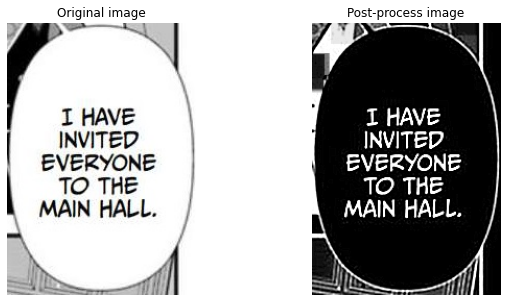

I HAVE INVITED EVERYONE TO THE MAIN HALL. 


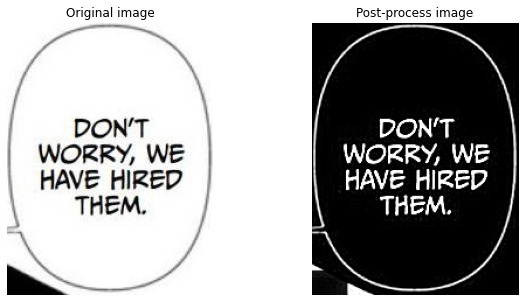

DON’T WORRY, WE HAVE HIRED THEM. 


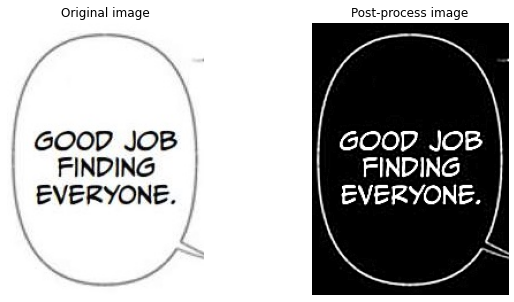

GOOD JOB FINDING EVERYONE. 


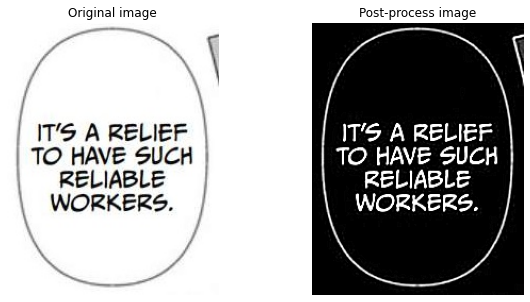

IT'S A RELIEF TO HAVE SUCH RELIABLE WORKERS. 


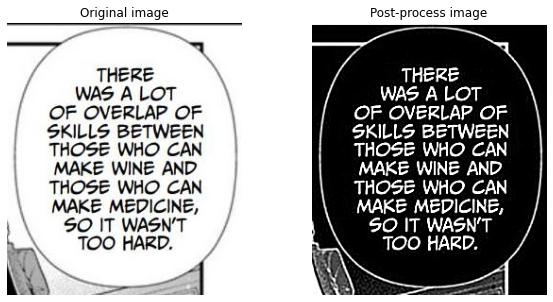

THERE WAS A LOT OF OVERLAP OF SKILLS BETWEEN THOSE WHO CAN MAKE WINE AND THOSE WHO CAN MAKE MEDICINE, SO IT WASN'T TOO HARD. 


In [2]:
en_dialogue = DirectoryProcessor.get_all_files("samples\MangaDialogue\EN")

for path in en_dialogue:
    
    color_image = Image.open(path)
    gray_image  = color_image.convert('L')
    image_array = np.array(gray_image)

    # Image processing
    image_array = ImageProcessing.blur(image_array, (3, 3))
    image_array = ImageProcessing.sharpening(image_array)
    image_array = ImageProcessing.blackhat(image_array, (21,21))

    text = Image2Text.eng(image_array, psm=4)
    if text == "":
        text = Image2Text.eng(image_array, psm=3)
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(color_image)
    plt.title("Original image")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(image_array, cmap='gray')
    plt.title("Post-process image")
    plt.axis('off')

    plt.show()

    print(text)

### Japanese Dialogues

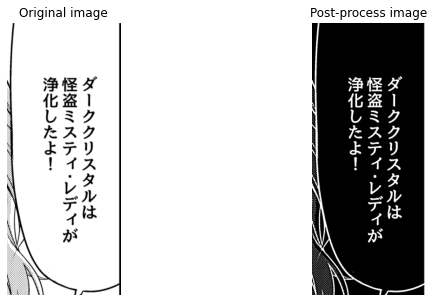

ダーククリスタルは怪盗ミスティ・レディが浄化したよ!


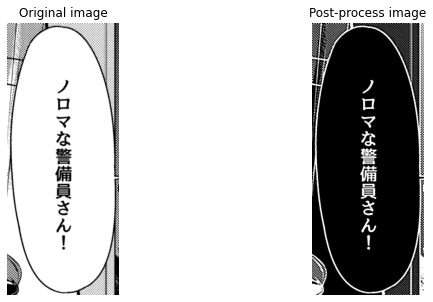

ノロマな警備員さん!


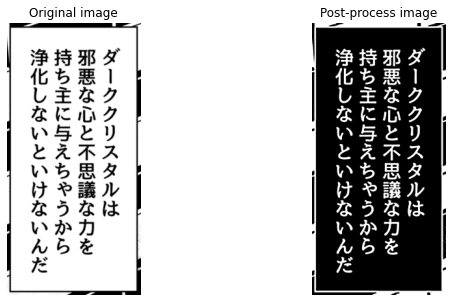

ダーククリスタルは邪悪な心と不思議な力を持ち主に与えちゃうから浄化しないといけないんだ


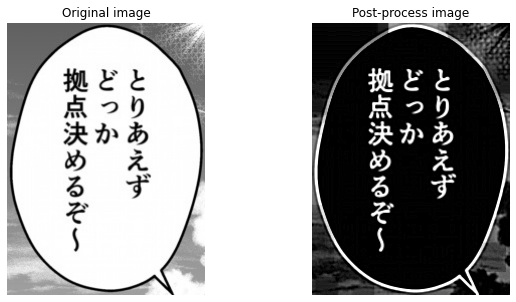

とりあえずどっか拠点決めるぞ~


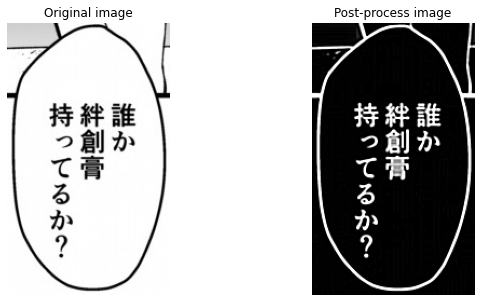

誰か絆創育持ってるか?・


In [3]:
jp_dialogue = DirectoryProcessor.get_all_files("samples\MangaDialogue\JP")

for path in jp_dialogue:
    color_image = Image.open(path)
    gray_image  = color_image.convert('L')
    image_array = np.array(gray_image)

    # Image processing
    image_array = ImageProcessing.blur(image_array, (5, 5))
    image_array = ImageProcessing.sharpening(image_array)
    image_array = ImageProcessing.blackhat(image_array, (21,21))

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(color_image)
    plt.title("Original image")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(image_array, cmap='gray')
    plt.title("Post-process image")
    plt.axis('off')
    
    plt.show()

    text = Image2Text.jpn_vert(image_array, psm=3)
    if text == "":
        text = Image2Text.jpn_vert(image_array, psm=5)

    print(text)

## Application Code

I process manga pages through my pre-trained YOLOv3 model to identify manga dialogues as object detection results. Then, I repeat the process above to extract text from the detection results for creating the "Manga Dialogue Detection with OCR Application".

In [4]:
import matplotlib.pyplot as plt

from module.object_detection.YOLOv3Decoder import YOLOv3Decoder
from module.utility.DirectoryProcessor import DirectoryProcessor
from module.utility.Initializer import Initializer

Initializer.set_gpu_memory_limit(MB=512)

CFG = {
    "h5file": r"export model\YOLOv3_640x640_a3_1Class_MangaDialog_fp16.h5",
    "dataset_dir": r"D:\Github Public\DATASET MANAGER\Manga Page\TEST",
    "label": ["Dialog"],
}

yolo = YOLOv3Decoder(
    CFG["h5file"],
    confidence_threshold=0.9,
    max_output=100,
    nms_iou=0.1,
    nms_confidence=0.5,
)

1 Physical GPUs, 1 Logical GPUs
Loading model ... INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5
COMPLETE


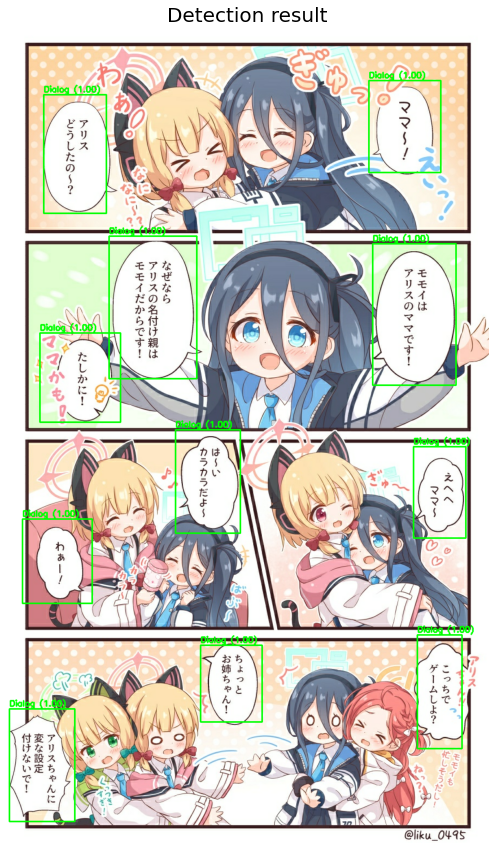

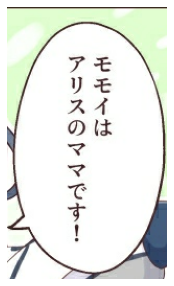

モモイはフリスのママです!


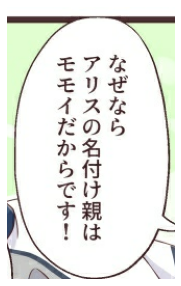

なぜならアリスの名付け親はモモイだからちです!


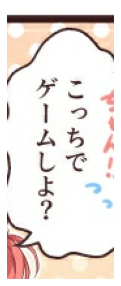

ジイルー)こっちで。ゲームしよ?


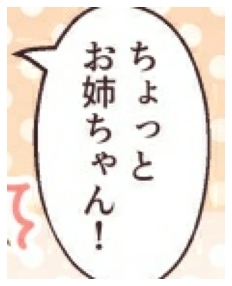

な有てて


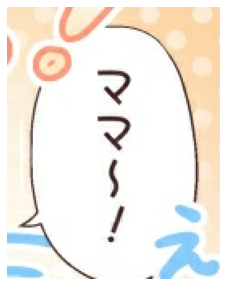

do\7』【


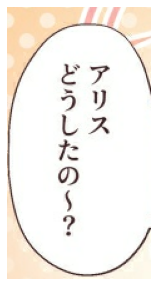

アリスどうしたの~?


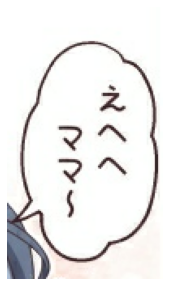

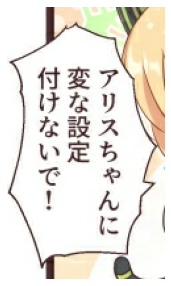

アリスちゃんに変な設定付けないで!


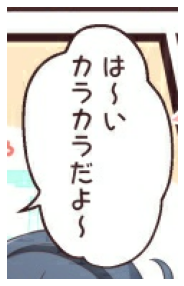

雇い|ご


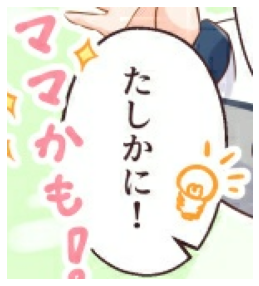

のとたしかに!ミ7もnp.ぐ<<で<みわ


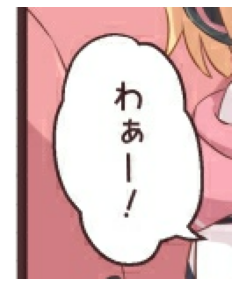

||。-時


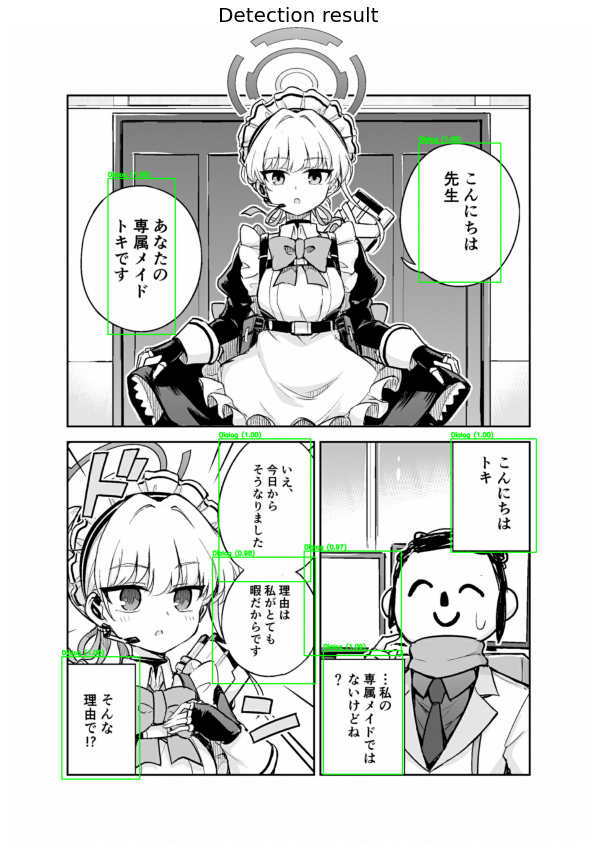

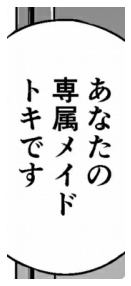

あなたの専属メイドッ>トキです"


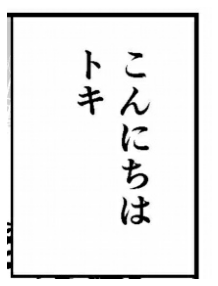

こんにおちトキ箕


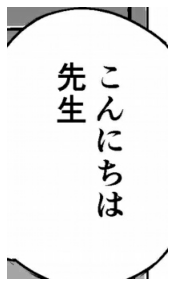

ミこんにち先生人


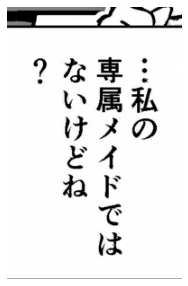

専属メイドではないけどね9?・


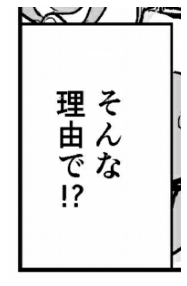

そんな二ーー理由で


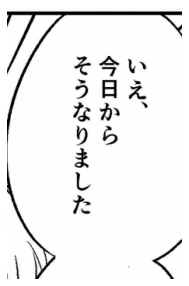

いえ、今日からそうなりました


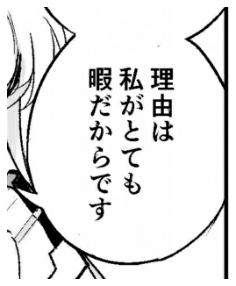

理由は私がとても暇だからです1//ト|


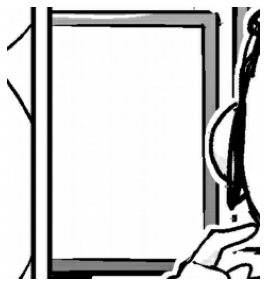

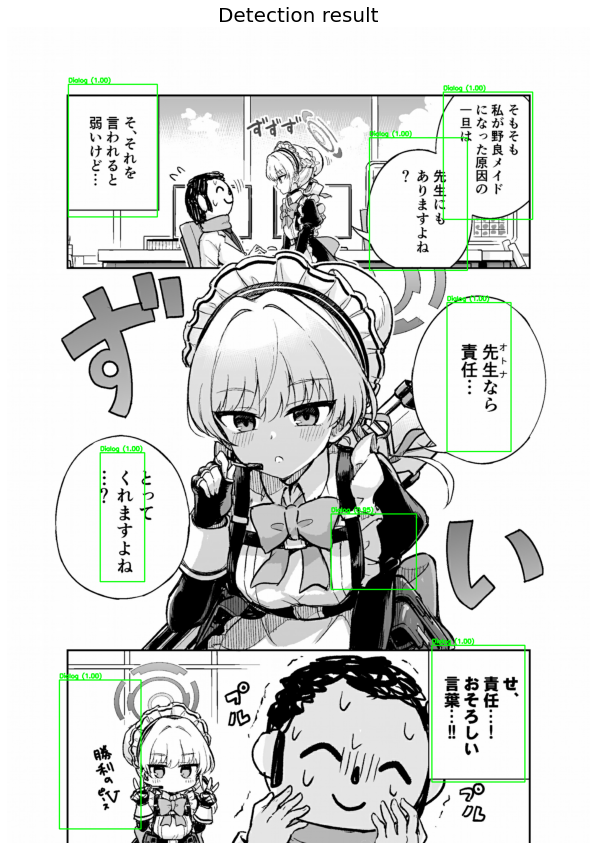

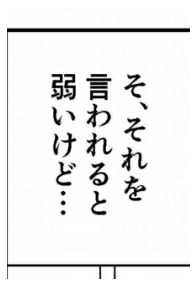

そ、それを言われると弱いけど…


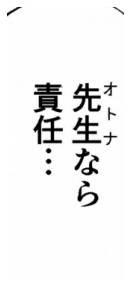

モオトナ先生なら責任…


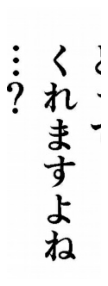

くれますよね:・9・


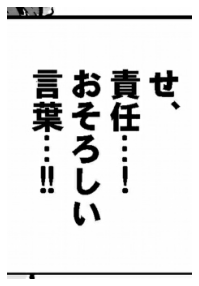

せ、責任…!おそろしい言葉…川


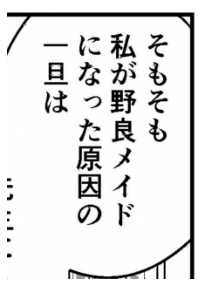

そもそも私が野良メイドになった原因の一旦は


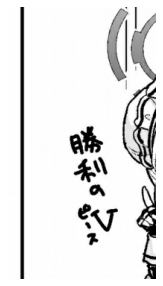

内。。


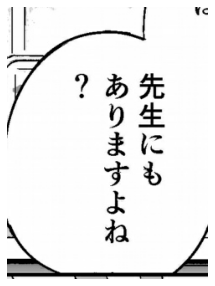

先生にもありますよね9・


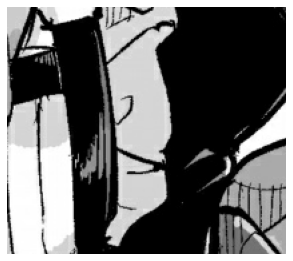

ノへmi=人EMで和


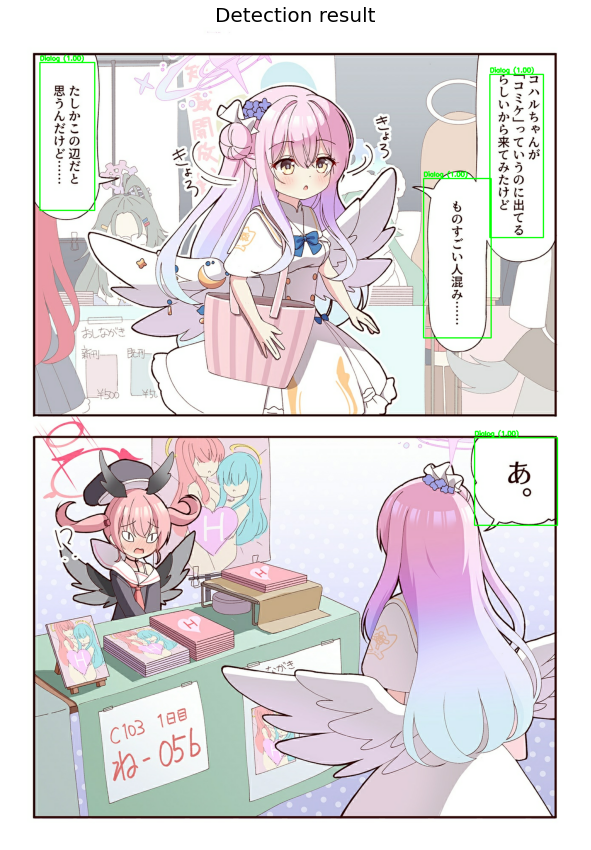

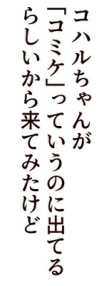

コハルちゃんが「コミケ」っていうのに出てるらしいから来てみたけど


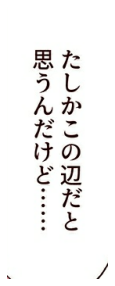

たしかこの辺だと思うんだけど:::


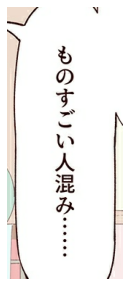

トト)|


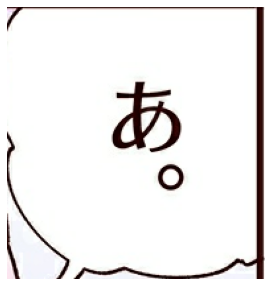

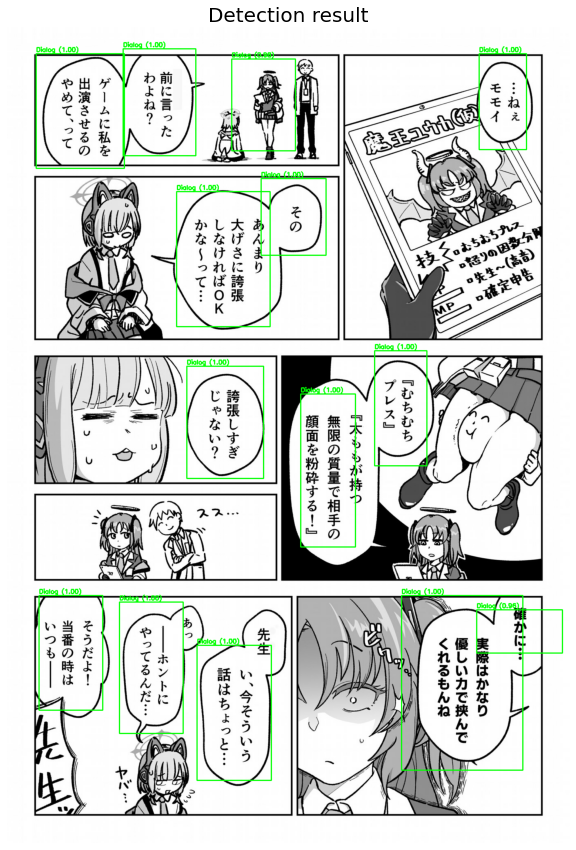

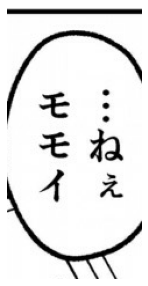

人


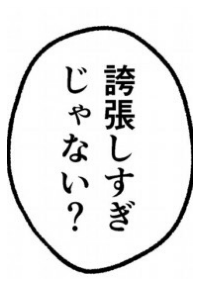

誇張しすぎじゃない?


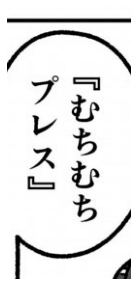

『むちさむプレス』


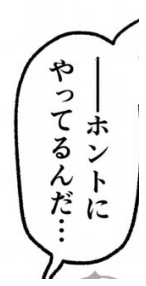

|ホントにやってるんだ…


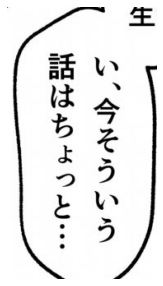

下人黄斑党揚人加記い、今そういう話はちょつと・…:


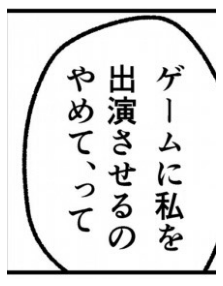

ゲームに私を出演させるのやめて、って


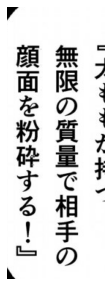

無限の質量で相手の顔面を粉砕する!』、デア


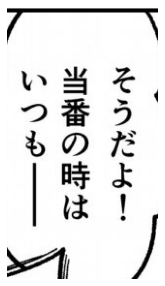

そうだよ!当番の時はいっもーー<


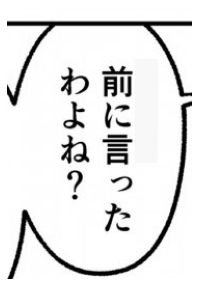

前に言ったわよね?


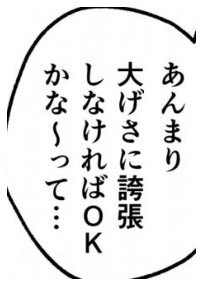

あんまりン大げさに誇張しなければOKかなけって\


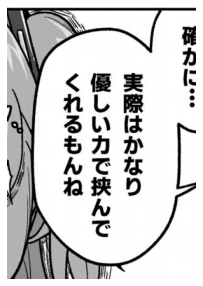

実際はかなり優しい力で挟んでくれるもんね


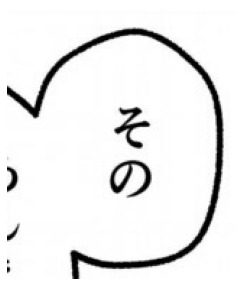

るCdシン


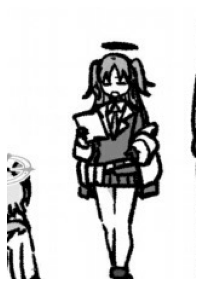

和公和平衝il


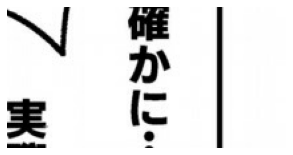

rr催かに・\


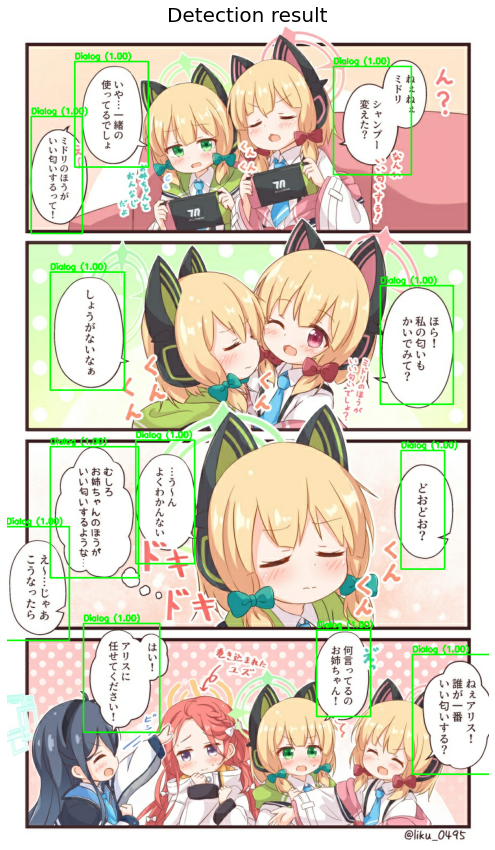

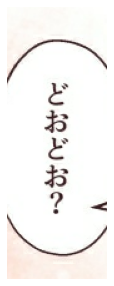

(と


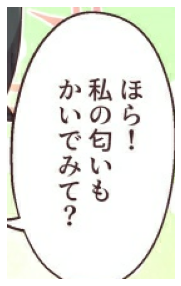

ほら!私の匂いもかいでみて?\


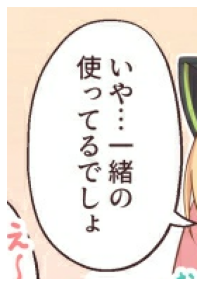

1し7いや…一緒の使ってるでしょNY\え|


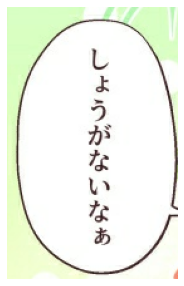

(1し


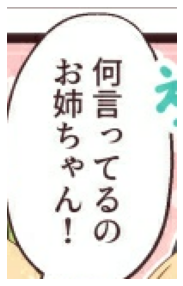

の何言ってるのお姉ちゃん!、\


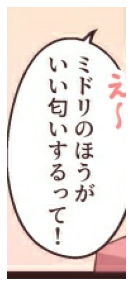

ミドリのほうがいい匂いするって!


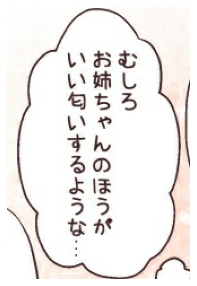

むしろお姉ちゃんのほうがいい匂いするような…


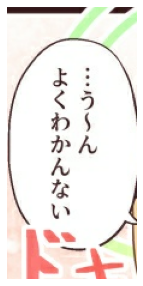

:…う~んンーよくわかんない)


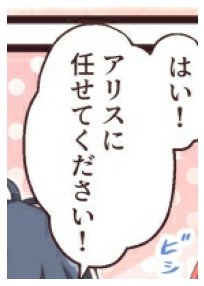

はい!ビンアリスに任せてください!いい、


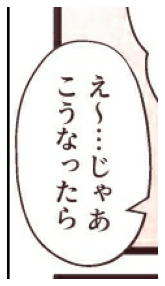

え~…じゃあこうなったらちら


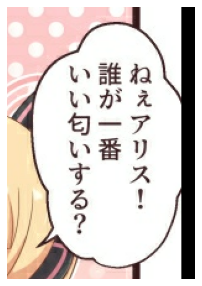

ねぇアリス!誰が一番いい匂いする?人ルリルル


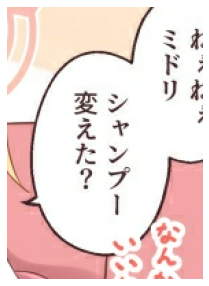

ミドリん人シャンプー、ヽい変えた?INN


In [5]:
path_list = DirectoryProcessor.get_all_files(CFG["dataset_dir"])

for path in path_list:
    yolo.show_detection(
        path, 
        CFG["label"], 
        figsize=(15,15),
    )

    detection_list = yolo.extract_detection(
        path, 
        CFG["label"], 
    )

    for detection in detection_list:
        gray_image = detection.convert('L')
        image_array = np.array(gray_image)

        # Image processing
        image_array = ImageProcessing.blur(image_array, (5, 5))
        image_array = ImageProcessing.sharpening(image_array)
        image_array = ImageProcessing.blackhat(image_array, (31,31))

        plt.figure(figsize=(5,5))
        plt.imshow(detection)
        plt.axis('off')
        plt.show()

        text = Image2Text.jpn_vert(image_array, psm=3)
        if text == "":
            text = Image2Text.jpn_vert(image_array, psm=5)

        print(text)

## Appendix

For OEM and PSM mode configuration are shown below:
```
$ tesseract --help-extra

OCR Engine Mode (OEM):
  0    Legacy engine only.
  1    Neural nets LSTM engine only.
  2    Legacy + LSTM engines.
  3    Default, based on what is available.

Page Segmentation Mode (PSM):
  0    Orientation and script detection (OSD) only.
  1    Automatic page segmentation with OSD.
  2    Automatic page segmentation, but no OSD, or OCR.
  3    Fully automatic page segmentation, but no OSD. (Default)
  4    Assume a single column of text of variable sizes.
  5    Assume a single uniform block of vertically aligned text.
  6    Assume a single uniform block of text.
  7    Treat the image as a single text line.
  8    Treat the image as a single word.
  9    Treat the image as a single word in a circle.
 10    Treat the image as a single character.
 11    Sparse text. Find as much text as possible in no particular order.
 12    Sparse text with OSD.
 13    Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.
```